# Step 1 Pre-Process Data

In [16]:
from pathlib import Path
from skimage.io import imread
import pandas as pd
import matplotlib.pyplot as plt

In /Users/demetri/opt/miniconda3/envs/hackshulich/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/demetri/opt/miniconda3/envs/hackshulich/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/demetri/opt/miniconda3/envs/hackshulich/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/demetri/opt/miniconda3/envs/hackshulich/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will b

In [3]:
# This is not in the repo because it is too big.
# Download it from the kaggle site and keep it in the repo.
data_dir = Path('sacm2021')

train = data_dir / 'TrainImages/TrainImages'
test = data_dir / 'TestImages/TestImages'


train_images = train.glob('*.png')
test_images = train.glob('*.png')


# Store a link to the image and the id together in a list
# Will turn into a dataframe later
# Image label is the numeric part of the image file name
# Will extract that using some ~~~string magic~~~
training_data_and_id = []

for img in train_images:
    
    image_id = (
        str(img).
        replace(str(train), '').
        replace('.png', '').
        replace('/','') 
    )
    
    image_id = int(image_id)
    
    training_data_and_id.append((img, image_id))
    

In [4]:
image_frame = pd.DataFrame(training_data_and_id, columns = ['img','id'])
labels = pd.read_csv('sacm2021/train.csv')

# Combine the labels and the image locations into a single frame
df = image_frame.merge(labels)

In [5]:
# Fairly even but not completely even
df.classification.value_counts(normalize=True).round(2)

2    0.35
0    0.23
1    0.22
3    0.21
Name: classification, dtype: float64

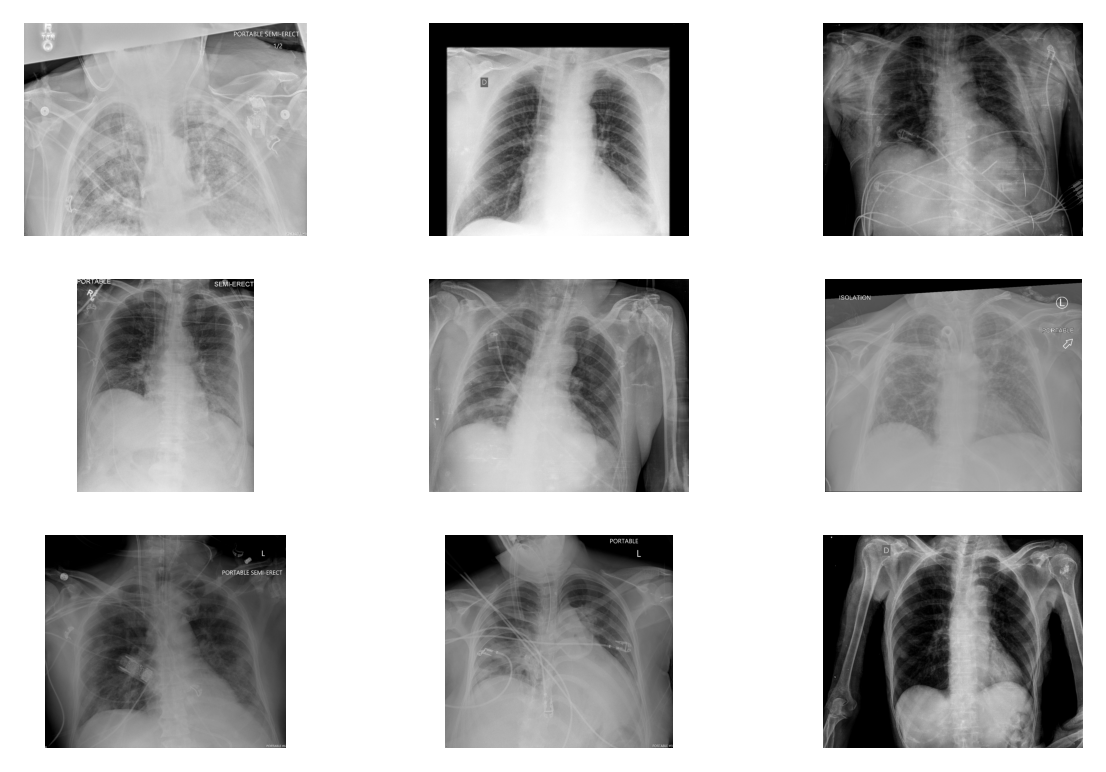

In [22]:
# What do a few of these look like?
fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3)
ax = ax.ravel()

for img, axis in zip(df.sample(9).img.tolist(), ax):
    xray = imread(img)
    axis.imshow(xray)
    axis.axis('off')